In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from random import shuffle
from matplotlib import cm

%matplotlib inline

np.random.seed(157)
error_tab = []
lr_tab = []
acc_tab = []

dfu = pd.read_csv('tae.data', header=None)

columns = ['English speaker', 'Course', 'Course instructor', 'Summer or regular semester', 'Class size', 'Class attribute']
dfu.columns = columns

# dfu.info()

df=dfu
df=((df-df.min())/(df.max()-df.min()))
df["Class attribute"]=dfu["Class attribute"]

'''
x = df.drop('Class attribute', axis=1).values
labels = df['Class attribute']
y = pd.get_dummies(df['Class attribute']).values
'''

"\nx = df.drop('Class attribute', axis=1).values\nlabels = df['Class attribute']\ny = pd.get_dummies(df['Class attribute']).values\n"

In [2]:
valid = df.sample(15)
train = df.drop(valid.index)

x = train.drop('Class attribute', axis=1).values
labels = train['Class attribute']
y = pd.get_dummies(train['Class attribute']).values

xt = valid.drop('Class attribute', axis=1).values
labels = valid['Class attribute']
yt = pd.get_dummies(valid['Class attribute']).values

In [3]:
valid.head(12)

,English speaker,Course,Course instructor,Summer or regular semester,Class size,Class attribute
48,1.0,0.583333,0.08,0.0,0.269841,3
77,1.0,0.541667,0.56,1.0,0.555556,1
117,1.0,0.916667,0.08,1.0,0.142857,1
146,1.0,0.083333,0.04,1.0,0.365079,1
122,1.0,0.333333,0.20,1.0,0.063492,3
25,1.0,0.250000,0.40,1.0,0.158730,2
135,1.0,0.458333,0.28,1.0,0.333333,2
60,1.0,1.000000,0.24,1.0,0.317460,2
112,0.0,0.541667,0.56,1.0,0.460317,1
110,1.0,0.375000,0.08,1.0,0.253968,1


In [4]:
def layer_sizes(X, Y):
    n_x = 5 # input layer
    n_h1 = 50
    n_h2 = 20
    n_y = 3 # output layer
    return (n_x, n_h1, n_h2, n_y)
        
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [5]:
def initialize_parameters(n_x, n_h1, n_h2, n_y):
    W1 = np.random.randn(n_x,n_h1)*0.01
    b1 = np.zeros(n_h1)

    W2 = np.random.randn(n_h1,n_h2)*0.01
    b2 = np.zeros(n_h2)

    W3 = np.random.randn(n_h2,n_y)*0.01
    b3 = np.zeros(n_y)

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [6]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Layer 1
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)

    # Layer 2
    Z2 = np.dot(A1, W2) + b2
    A2 = sigmoid(Z2)
    
    # Layer 3
    Z3 = np.dot(A2, W3) + b3
    A3 = sigmoid(Z3)
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2,
             "Z3": Z3,
             "A3": A3}
    
    return A3, cache

In [7]:
def compute_cost(A3, Y, parameters):
    m = Y.shape[0] # number of examples
    # cross entropy
    logprobs = np.multiply(np.log(A3), Y) + np.multiply((1 - Y), np.log(1 - A3))
    cost = - np.sum(logprobs) / m    
    
    cost = np.squeeze(cost)
    
    return cost*100

In [8]:
def accuracy(output_vec, test_vec):
    equals = np.equal(np.argmax(test_vec, axis=1), np.argmax(output_vec, axis=1))
    acc = np.mean(equals)
    return acc

In [9]:
def adapt_learning_rate(learning_rate, xi_d, xi_i, er_r, cost, prev_cost):
    if cost > er_r*prev_cost:
        learning_rate*=xi_d
    elif cost < prev_cost:
        learning_rate*=xi_i
    prev_cost = cost
    return learning_rate, prev_cost

In [10]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache['A1']
    A2 = cache['A2']
    A3 = cache['A3']
    
    Z1 = cache['Z1']
    Z2 = cache['Z2']
    
    ########## Layer 3
    delta3 = A3-Y
    dW3 = np.dot(A2.T, delta3)
    db3 = delta3
    
    ########## Layer 2
    delta2 = np.dot(delta3, W3.T) * sigmoid_prime(Z2)
    dW2 = np.dot(A1.T, delta2)
    db2 = delta2
    
    ########## Layer 1
    delta1 = np.dot(delta2, W2.T) * sigmoid_prime(Z1)
    dW1 = np.dot(X.T, delta1)
    db1 = delta1

    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,       
             "dW3": dW3,
             "db3": db3}
    return grads

In [11]:
def update_parameters(parameters, grads, learning_rate):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    dW3 = grads['dW3']
    db3 = grads['db3']

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1.sum(axis=0)

    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2.sum(axis=0)
    
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3.sum(axis=0)
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [12]:
def nn_model(X, Y, n_h1, n_h2, er_r, xi_i, xi_d, num_iterations, learning_rate):
    prev_cost = 1000.0
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[3]
    
    parameters = initialize_parameters(n_x, n_h1, n_h2, n_y)
 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    max_acc = 0;
    
    for epoch in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A3, cache = forward_propagation(X, parameters)

        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A3, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
        
        # CONSTANT LEARNING RATE:
        # learning_rate = 0.01
        
        # DECREMENTAL LEARNING RATE:
        # learning_rate *= 1/(1 + learning_rate/(epoch+1) * epoch)
        
        # ADAPTIVE LEARNING RATE:
        learning_rate, prev_cost = adapt_learning_rate(learning_rate, xi_d, xi_i, er_r, cost, prev_cost)

        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate)

            #loss = -np.sum(y * np.log(A3))
            #error_tab.append(cost)
            #lr_tab.append(learning_rate)
            # equals = np.equal(np.argmax(y, axis=1), np.argmax(A3, axis=1))
            # acc = np.mean(equals)
            # A3, cache = forward_propagation(xt, parameters)
            # equals = np.equal(np.argmax(yt, axis=1), np.argmax(A3, axis=1))
            # acc_t = np.mean(equals)
            # acc_tab.append(acc)
            # print("Cost after iteration %i: %f, accuracy: %f" %(epoch, acc, acc_t))

    return parameters, A3

In [13]:
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

In [14]:
# plt.plot(range(len(acc_tab)), acc_tab)

In [15]:
# LAYERS SIZE
n_number = list(range(1, 101, 1))
acc_tab = np.zeros(shape=(100,100))
for n_h1 in n_number:
    for n_h2 in n_number:
        parameters, A3 = nn_model(x, y, n_h1, n_h2, er_r = 1.016, xi_i = 1.06, xi_d = 0.77, num_iterations = 4800, learning_rate = 0.01)
        acc = accuracy(output_vec = A3, test_vec = y)
        A3, cache = forward_propagation(xt, parameters)
        acc_t = accuracy(output_vec = A3, test_vec = yt)
        print("{}, {}, {}, {}".format(n_h1, n_h2, acc, acc_t))
        acc_tab[n_h1-1, n_h2-1] = acc*acc_t

1, 1, 0.5514705882352942, 0.5333333333333333
1, 2, 0.5955882352941176, 0.6
1, 3, 0.6029411764705882, 0.5333333333333333
1, 4, 0.5882352941176471, 0.5333333333333333
1, 5, 0.47058823529411764, 0.6
1, 6, 0.5, 0.5333333333333333
1, 7, 0.5147058823529411, 0.5333333333333333
1, 8, 0.5073529411764706, 0.5333333333333333
1, 9, 0.4852941176470588, 0.5333333333333333
1, 10, 0.5147058823529411, 0.5333333333333333
1, 11, 0.49264705882352944, 0.5333333333333333
1, 12, 0.5073529411764706, 0.5333333333333333
1, 13, 0.5147058823529411, 0.5333333333333333
1, 14, 0.5367647058823529, 0.5333333333333333
1, 15, 0.5441176470588235, 0.5333333333333333
1, 16, 0.5147058823529411, 0.5333333333333333
1, 17, 0.5147058823529411, 0.5333333333333333
1, 18, 0.5294117647058824, 0.6
1, 19, 0.5294117647058824, 0.5333333333333333
1, 20, 0.5441176470588235, 0.5333333333333333
1, 21, 0.5294117647058824, 0.5333333333333333
1, 22, 0.5441176470588235, 0.5333333333333333
1, 23, 0.5441176470588235, 0.5333333333333333
1, 24, 0.

2, 96, 0.5808823529411765, 0.6
2, 97, 0.6176470588235294, 0.6666666666666666
2, 98, 0.625, 0.6666666666666666
2, 99, 0.5808823529411765, 0.6
2, 100, 0.6176470588235294, 0.5333333333333333
3, 1, 0.5441176470588235, 0.4
3, 2, 0.6838235294117647, 0.6
3, 3, 0.6691176470588235, 0.6
3, 4, 0.6764705882352942, 0.6666666666666666
3, 5, 0.5661764705882353, 0.4666666666666667
3, 6, 0.6764705882352942, 0.6
3, 7, 0.6691176470588235, 0.6
3, 8, 0.6397058823529411, 0.6
3, 9, 0.6470588235294118, 0.6
3, 10, 0.6323529411764706, 0.5333333333333333
3, 11, 0.6323529411764706, 0.5333333333333333
3, 12, 0.6323529411764706, 0.5333333333333333
3, 13, 0.6323529411764706, 0.5333333333333333
3, 14, 0.6323529411764706, 0.5333333333333333
3, 15, 0.6470588235294118, 0.5333333333333333
3, 16, 0.625, 0.5333333333333333
3, 17, 0.6323529411764706, 0.5333333333333333
3, 18, 0.6323529411764706, 0.5333333333333333
3, 19, 0.625, 0.5333333333333333
3, 20, 0.6102941176470589, 0.5333333333333333
3, 21, 0.6102941176470589, 0.533

c:\users\fryderyk\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
c:\users\fryderyk\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


3, 92, 0.4117647058823529, 0.3333333333333333
3, 93, 0.5955882352941176, 0.5333333333333333
3, 94, 0.5808823529411765, 0.5333333333333333
3, 95, 0.5735294117647058, 0.5333333333333333
3, 96, 0.6102941176470589, 0.4666666666666667
3, 97, 0.6102941176470589, 0.5333333333333333
3, 98, 0.5882352941176471, 0.5333333333333333
3, 99, 0.6397058823529411, 0.6
3, 100, 0.6323529411764706, 0.6666666666666666
4, 1, 0.5220588235294118, 0.5333333333333333
4, 2, 0.34558823529411764, 0.26666666666666666
4, 3, 0.6544117647058824, 0.5333333333333333
4, 4, 0.6911764705882353, 0.6
4, 5, 0.5735294117647058, 0.5333333333333333
4, 6, 0.7132352941176471, 0.6666666666666666
4, 7, 0.6911764705882353, 0.6
4, 8, 0.6985294117647058, 0.6
4, 9, 0.6691176470588235, 0.5333333333333333
4, 10, 0.6617647058823529, 0.6
4, 11, 0.6911764705882353, 0.6
4, 12, 0.5073529411764706, 0.4666666666666667
4, 13, 0.6323529411764706, 0.5333333333333333
4, 14, 0.6617647058823529, 0.6
4, 15, 0.6617647058823529, 0.5333333333333333
4, 16, 

5, 99, 0.5955882352941176, 0.4666666666666667
5, 100, 0.6911764705882353, 0.6666666666666666
6, 1, 0.3161764705882353, 0.3333333333333333
6, 2, 0.39705882352941174, 0.26666666666666666
6, 3, 0.6617647058823529, 0.6
6, 4, 0.7205882352941176, 0.6666666666666666
6, 5, 0.6764705882352942, 0.4666666666666667
6, 6, 0.6691176470588235, 0.6666666666666666
6, 7, 0.7279411764705882, 0.4666666666666667
6, 8, 0.7279411764705882, 0.6666666666666666
6, 9, 0.7132352941176471, 0.6666666666666666
6, 10, 0.7132352941176471, 0.5333333333333333
6, 11, 0.7058823529411765, 0.6
6, 12, 0.6911764705882353, 0.5333333333333333
6, 13, 0.6985294117647058, 0.6666666666666666
6, 14, 0.7205882352941176, 0.7333333333333333
6, 15, 0.7132352941176471, 0.7333333333333333
6, 16, 0.7058823529411765, 0.6
6, 17, 0.7132352941176471, 0.6
6, 18, 0.6911764705882353, 0.6
6, 19, 0.6691176470588235, 0.6
6, 20, 0.6838235294117647, 0.6
6, 21, 0.7279411764705882, 0.7333333333333333
6, 22, 0.75, 0.6
6, 23, 0.6838235294117647, 0.6666666

7, 99, 0.6544117647058824, 0.6666666666666666
7, 100, 0.6838235294117647, 0.4
8, 1, 0.3161764705882353, 0.3333333333333333
8, 2, 0.6470588235294118, 0.5333333333333333
8, 3, 0.3382352941176471, 0.3333333333333333
8, 4, 0.6764705882352942, 0.4666666666666667
8, 5, 0.6691176470588235, 0.6
8, 6, 0.39705882352941174, 0.3333333333333333
8, 7, 0.7426470588235294, 0.6
8, 8, 0.7132352941176471, 0.4666666666666667
8, 9, 0.7058823529411765, 0.6
8, 10, 0.7573529411764706, 0.6
8, 11, 0.6985294117647058, 0.6
8, 12, 0.6838235294117647, 0.5333333333333333
8, 13, 0.7279411764705882, 0.6
8, 14, 0.7426470588235294, 0.6
8, 15, 0.7426470588235294, 0.6
8, 16, 0.75, 0.5333333333333333
8, 17, 0.7426470588235294, 0.6
8, 18, 0.75, 0.6
8, 19, 0.7205882352941176, 0.6666666666666666
8, 20, 0.7058823529411765, 0.6
8, 21, 0.7205882352941176, 0.6666666666666666
8, 22, 0.6764705882352942, 0.6
8, 23, 0.7132352941176471, 0.6
8, 24, 0.75, 0.6
8, 25, 0.6691176470588235, 0.6666666666666666
8, 26, 0.7132352941176471, 0.466

10, 2, 0.5808823529411765, 0.4666666666666667
10, 3, 0.7426470588235294, 0.6666666666666666
10, 4, 0.4338235294117647, 0.3333333333333333
10, 5, 0.7058823529411765, 0.5333333333333333
10, 6, 0.7058823529411765, 0.6666666666666666
10, 7, 0.6544117647058824, 0.6666666666666666
10, 8, 0.7352941176470589, 0.5333333333333333
10, 9, 0.7647058823529411, 0.5333333333333333
10, 10, 0.7573529411764706, 0.6
10, 11, 0.7352941176470589, 0.4666666666666667
10, 12, 0.7352941176470589, 0.6
10, 13, 0.7132352941176471, 0.6666666666666666
10, 14, 0.7058823529411765, 0.6
10, 15, 0.6911764705882353, 0.6
10, 16, 0.7573529411764706, 0.4
10, 17, 0.7279411764705882, 0.6
10, 18, 0.7058823529411765, 0.6
10, 19, 0.6838235294117647, 0.6
10, 20, 0.6691176470588235, 0.6
10, 21, 0.7205882352941176, 0.6666666666666666
10, 22, 0.6911764705882353, 0.6666666666666666
10, 23, 0.6985294117647058, 0.6666666666666666
10, 24, 0.7426470588235294, 0.5333333333333333
10, 25, 0.7132352941176471, 0.6
10, 26, 0.6911764705882353, 0.

12, 6, 0.7352941176470589, 0.6
12, 7, 0.7132352941176471, 0.6
12, 8, 0.7279411764705882, 0.6
12, 9, 0.7867647058823529, 0.6
12, 10, 0.7720588235294118, 0.5333333333333333
12, 11, 0.75, 0.5333333333333333
12, 12, 0.7426470588235294, 0.5333333333333333
12, 13, 0.7352941176470589, 0.4
12, 14, 0.7426470588235294, 0.5333333333333333
12, 15, 0.7058823529411765, 0.5333333333333333
12, 16, 0.7426470588235294, 0.5333333333333333
12, 17, 0.8455882352941176, 0.5333333333333333
12, 18, 0.7058823529411765, 0.5333333333333333
12, 19, 0.7279411764705882, 0.4666666666666667
12, 20, 0.6911764705882353, 0.5333333333333333
12, 21, 0.7647058823529411, 0.6666666666666666
12, 22, 0.7058823529411765, 0.6
12, 23, 0.7426470588235294, 0.6666666666666666
12, 24, 0.7132352941176471, 0.6666666666666666
12, 25, 0.7279411764705882, 0.6666666666666666
12, 26, 0.6911764705882353, 0.6666666666666666
12, 27, 0.75, 0.4666666666666667
12, 28, 0.7279411764705882, 0.5333333333333333
12, 29, 0.7647058823529411, 0.53333333333

14, 5, 0.7426470588235294, 0.7333333333333333
14, 6, 0.75, 0.6666666666666666
14, 7, 0.7058823529411765, 0.6666666666666666
14, 8, 0.7573529411764706, 0.6666666666666666
14, 9, 0.6985294117647058, 0.4666666666666667
14, 10, 0.7720588235294118, 0.6
14, 11, 0.7647058823529411, 0.4666666666666667
14, 12, 0.6985294117647058, 0.6666666666666666
14, 13, 0.7867647058823529, 0.5333333333333333
14, 14, 0.6911764705882353, 0.6
14, 15, 0.7352941176470589, 0.4666666666666667
14, 16, 0.7426470588235294, 0.6
14, 17, 0.7058823529411765, 0.6
14, 18, 0.7426470588235294, 0.5333333333333333
14, 19, 0.7279411764705882, 0.4666666666666667
14, 20, 0.7426470588235294, 0.6
14, 21, 0.7426470588235294, 0.5333333333333333
14, 22, 0.7426470588235294, 0.5333333333333333
14, 23, 0.7426470588235294, 0.5333333333333333
14, 24, 0.7058823529411765, 0.6666666666666666
14, 25, 0.6985294117647058, 0.6
14, 26, 0.7279411764705882, 0.6666666666666666
14, 27, 0.7279411764705882, 0.6666666666666666
14, 28, 0.7794117647058824, 

16, 2, 0.3161764705882353, 0.3333333333333333
16, 3, 0.34558823529411764, 0.4
16, 4, 0.6838235294117647, 0.5333333333333333
16, 5, 0.7352941176470589, 0.6
16, 6, 0.7794117647058824, 0.6666666666666666
16, 7, 0.7647058823529411, 0.6666666666666666
16, 8, 0.7279411764705882, 0.5333333333333333
16, 9, 0.7426470588235294, 0.6
16, 10, 0.7279411764705882, 0.6
16, 11, 0.75, 0.5333333333333333
16, 12, 0.8014705882352942, 0.6
16, 13, 0.7647058823529411, 0.6
16, 14, 0.75, 0.5333333333333333
16, 15, 0.7867647058823529, 0.6
16, 16, 0.8235294117647058, 0.6
16, 17, 0.6764705882352942, 0.6
16, 18, 0.8014705882352942, 0.5333333333333333
16, 19, 0.7573529411764706, 0.6
16, 20, 0.7279411764705882, 0.5333333333333333
16, 21, 0.7132352941176471, 0.6
16, 22, 0.7941176470588235, 0.5333333333333333
16, 23, 0.7279411764705882, 0.6
16, 24, 0.7352941176470589, 0.6
16, 25, 0.7352941176470589, 0.6666666666666666
16, 26, 0.7426470588235294, 0.6666666666666666
16, 27, 0.7205882352941176, 0.3333333333333333
16, 28, 

18, 6, 0.7426470588235294, 0.5333333333333333
18, 7, 0.7205882352941176, 0.6666666666666666
18, 8, 0.7352941176470589, 0.5333333333333333
18, 9, 0.8014705882352942, 0.6
18, 10, 0.7647058823529411, 0.5333333333333333
18, 11, 0.7058823529411765, 0.4666666666666667
18, 12, 0.8014705882352942, 0.5333333333333333
18, 13, 0.7647058823529411, 0.4666666666666667
18, 14, 0.7867647058823529, 0.6
18, 15, 0.7279411764705882, 0.6
18, 16, 0.7720588235294118, 0.5333333333333333
18, 17, 0.7426470588235294, 0.6
18, 18, 0.7794117647058824, 0.6
18, 19, 0.7279411764705882, 0.6
18, 20, 0.8088235294117647, 0.5333333333333333
18, 21, 0.7352941176470589, 0.6666666666666666
18, 22, 0.7352941176470589, 0.5333333333333333
18, 23, 0.7279411764705882, 0.5333333333333333
18, 24, 0.6838235294117647, 0.5333333333333333
18, 25, 0.7132352941176471, 0.6
18, 26, 0.7426470588235294, 0.6
18, 27, 0.7720588235294118, 0.5333333333333333
18, 28, 0.7058823529411765, 0.5333333333333333
18, 29, 0.6838235294117647, 0.5333333333333

20, 2, 0.6838235294117647, 0.6
20, 3, 0.5808823529411765, 0.5333333333333333
20, 4, 0.625, 0.5333333333333333
20, 5, 0.6985294117647058, 0.6
20, 6, 0.7279411764705882, 0.6
20, 7, 0.7794117647058824, 0.5333333333333333
20, 8, 0.7058823529411765, 0.6666666666666666
20, 9, 0.6985294117647058, 0.5333333333333333
20, 10, 0.7573529411764706, 0.6
20, 11, 0.7132352941176471, 0.5333333333333333
20, 12, 0.7573529411764706, 0.4666666666666667
20, 13, 0.7279411764705882, 0.5333333333333333
20, 14, 0.7647058823529411, 0.5333333333333333
20, 15, 0.7794117647058824, 0.5333333333333333
20, 16, 0.6691176470588235, 0.5333333333333333
20, 17, 0.7352941176470589, 0.5333333333333333
20, 18, 0.7794117647058824, 0.5333333333333333
20, 19, 0.7794117647058824, 0.6
20, 20, 0.7720588235294118, 0.6
20, 21, 0.75, 0.5333333333333333
20, 22, 0.6985294117647058, 0.5333333333333333
20, 23, 0.7058823529411765, 0.3333333333333333
20, 24, 0.7058823529411765, 0.4666666666666667
20, 25, 0.75, 0.5333333333333333
20, 26, 0.7

21, 97, 0.7205882352941176, 0.5333333333333333
21, 98, 0.7132352941176471, 0.5333333333333333
21, 99, 0.7720588235294118, 0.6
21, 100, 0.7720588235294118, 0.5333333333333333
22, 1, 0.34558823529411764, 0.4
22, 2, 0.34558823529411764, 0.4
22, 3, 0.34558823529411764, 0.26666666666666666
22, 4, 0.625, 0.4666666666666667
22, 5, 0.7205882352941176, 0.4666666666666667
22, 6, 0.7573529411764706, 0.7333333333333333
22, 7, 0.7426470588235294, 0.6
22, 8, 0.7132352941176471, 0.5333333333333333
22, 9, 0.7279411764705882, 0.4666666666666667
22, 10, 0.75, 0.5333333333333333
22, 11, 0.7279411764705882, 0.4666666666666667
22, 12, 0.7205882352941176, 0.4666666666666667
22, 13, 0.7647058823529411, 0.6
22, 14, 0.6911764705882353, 0.6666666666666666
22, 15, 0.7279411764705882, 0.5333333333333333
22, 16, 0.6764705882352942, 0.5333333333333333
22, 17, 0.7205882352941176, 0.5333333333333333
22, 18, 0.7794117647058824, 0.5333333333333333
22, 19, 0.6911764705882353, 0.5333333333333333
22, 20, 0.764705882352941

23, 98, 0.625, 0.6
23, 99, 0.75, 0.6666666666666666
23, 100, 0.8088235294117647, 0.6
24, 1, 0.3161764705882353, 0.3333333333333333
24, 2, 0.34558823529411764, 0.4
24, 3, 0.3161764705882353, 0.3333333333333333
24, 4, 0.6911764705882353, 0.6666666666666666
24, 5, 0.6838235294117647, 0.6
24, 6, 0.7279411764705882, 0.8
24, 7, 0.7794117647058824, 0.6
24, 8, 0.7279411764705882, 0.5333333333333333
24, 9, 0.7573529411764706, 0.6
24, 10, 0.7426470588235294, 0.6666666666666666
24, 11, 0.7205882352941176, 0.6
24, 12, 0.7279411764705882, 0.5333333333333333
24, 13, 0.7352941176470589, 0.5333333333333333
24, 14, 0.7647058823529411, 0.6
24, 15, 0.7573529411764706, 0.6
24, 16, 0.7058823529411765, 0.5333333333333333
24, 17, 0.7205882352941176, 0.4666666666666667
24, 18, 0.7941176470588235, 0.4
24, 19, 0.7352941176470589, 0.4666666666666667
24, 20, 0.75, 0.5333333333333333
24, 21, 0.7279411764705882, 0.6666666666666666
24, 22, 0.7058823529411765, 0.5333333333333333
24, 23, 0.6985294117647058, 0.46666666

26, 1, 0.3161764705882353, 0.3333333333333333
26, 2, 0.34558823529411764, 0.4
26, 3, 0.3161764705882353, 0.3333333333333333
26, 4, 0.6470588235294118, 0.6666666666666666
26, 5, 0.7058823529411765, 0.5333333333333333
26, 6, 0.7426470588235294, 0.6666666666666666
26, 7, 0.7941176470588235, 0.6
26, 8, 0.7794117647058824, 0.6
26, 9, 0.75, 0.6
26, 10, 0.7941176470588235, 0.5333333333333333
26, 11, 0.7720588235294118, 0.5333333333333333
26, 12, 0.7941176470588235, 0.5333333333333333
26, 13, 0.7720588235294118, 0.4666666666666667
26, 14, 0.7720588235294118, 0.5333333333333333
26, 15, 0.7352941176470589, 0.4
26, 16, 0.7794117647058824, 0.5333333333333333
26, 17, 0.6617647058823529, 0.4
26, 18, 0.7426470588235294, 0.6
26, 19, 0.7573529411764706, 0.5333333333333333
26, 20, 0.7647058823529411, 0.5333333333333333
26, 21, 0.7647058823529411, 0.4666666666666667
26, 22, 0.7573529411764706, 0.6
26, 23, 0.7279411764705882, 0.4666666666666667
26, 24, 0.6911764705882353, 0.4666666666666667
26, 25, 0.6691

28, 5, 0.7352941176470589, 0.6666666666666666
28, 6, 0.6911764705882353, 0.4666666666666667
28, 7, 0.7720588235294118, 0.6666666666666666
28, 8, 0.7647058823529411, 0.6
28, 9, 0.5808823529411765, 0.5333333333333333
28, 10, 0.7352941176470589, 0.6
28, 11, 0.6691176470588235, 0.4666666666666667
28, 12, 0.8088235294117647, 0.6666666666666666
28, 13, 0.7794117647058824, 0.6
28, 14, 0.7941176470588235, 0.4666666666666667
28, 15, 0.8235294117647058, 0.5333333333333333
28, 16, 0.7720588235294118, 0.4666666666666667
28, 17, 0.7426470588235294, 0.6
28, 18, 0.75, 0.5333333333333333
28, 19, 0.7573529411764706, 0.4666666666666667
28, 20, 0.7279411764705882, 0.4666666666666667
28, 21, 0.7352941176470589, 0.5333333333333333
28, 22, 0.75, 0.4666666666666667
28, 23, 0.7352941176470589, 0.4666666666666667
28, 24, 0.7720588235294118, 0.6
28, 25, 0.7867647058823529, 0.6
28, 26, 0.7867647058823529, 0.6
28, 27, 0.6838235294117647, 0.6666666666666666
28, 28, 0.7867647058823529, 0.5333333333333333
28, 29, 0.

30, 9, 0.7573529411764706, 0.5333333333333333
30, 10, 0.7205882352941176, 0.6666666666666666
30, 11, 0.75, 0.4666666666666667
30, 12, 0.7573529411764706, 0.4666666666666667
30, 13, 0.7647058823529411, 0.6
30, 14, 0.7867647058823529, 0.6
30, 15, 0.7573529411764706, 0.6
30, 16, 0.7720588235294118, 0.6
30, 17, 0.75, 0.5333333333333333
30, 18, 0.7941176470588235, 0.5333333333333333
30, 19, 0.75, 0.6
30, 20, 0.7794117647058824, 0.4666666666666667
30, 21, 0.7794117647058824, 0.6
30, 22, 0.7720588235294118, 0.5333333333333333
30, 23, 0.8088235294117647, 0.4666666666666667
30, 24, 0.6911764705882353, 0.5333333333333333
30, 25, 0.7426470588235294, 0.4666666666666667
30, 26, 0.7426470588235294, 0.4666666666666667
30, 27, 0.7647058823529411, 0.7333333333333333
30, 28, 0.7647058823529411, 0.5333333333333333
30, 29, 0.7794117647058824, 0.4666666666666667
30, 30, 0.8014705882352942, 0.5333333333333333
30, 31, 0.7794117647058824, 0.6
30, 32, 0.7647058823529411, 0.6
30, 33, 0.6985294117647058, 0.73333

32, 14, 0.7720588235294118, 0.4
32, 15, 0.75, 0.6666666666666666
32, 16, 0.75, 0.5333333333333333
32, 17, 0.7352941176470589, 0.4666666666666667
32, 18, 0.7941176470588235, 0.5333333333333333
32, 19, 0.75, 0.5333333333333333
32, 20, 0.7132352941176471, 0.4666666666666667
32, 21, 0.75, 0.4
32, 22, 0.75, 0.8
32, 23, 0.7573529411764706, 0.6666666666666666
32, 24, 0.7647058823529411, 0.4666666666666667
32, 25, 0.7794117647058824, 0.5333333333333333
32, 26, 0.7941176470588235, 0.5333333333333333
32, 27, 0.75, 0.6
32, 28, 0.8088235294117647, 0.6
32, 29, 0.8161764705882353, 0.6
32, 30, 0.7867647058823529, 0.5333333333333333
32, 31, 0.7573529411764706, 0.6666666666666666
32, 32, 0.8382352941176471, 0.5333333333333333
32, 33, 0.7132352941176471, 0.6666666666666666
32, 34, 0.8235294117647058, 0.6
32, 35, 0.7647058823529411, 0.6666666666666666
32, 36, 0.8235294117647058, 0.5333333333333333
32, 37, 0.7794117647058824, 0.5333333333333333
32, 38, 0.7720588235294118, 0.5333333333333333
32, 39, 0.7573

34, 15, 0.7426470588235294, 0.4666666666666667
34, 16, 0.7426470588235294, 0.5333333333333333
34, 17, 0.7279411764705882, 0.4666666666666667
34, 18, 0.7426470588235294, 0.6
34, 19, 0.7720588235294118, 0.6666666666666666
34, 20, 0.75, 0.4
34, 21, 0.7941176470588235, 0.5333333333333333
34, 22, 0.7720588235294118, 0.5333333333333333
34, 23, 0.8014705882352942, 0.4666666666666667
34, 24, 0.7647058823529411, 0.5333333333333333
34, 25, 0.7279411764705882, 0.6666666666666666
34, 26, 0.7352941176470589, 0.5333333333333333
34, 27, 0.7426470588235294, 0.5333333333333333
34, 28, 0.7279411764705882, 0.5333333333333333
34, 29, 0.6544117647058824, 0.5333333333333333
34, 30, 0.7647058823529411, 0.6666666666666666
34, 31, 0.75, 0.6666666666666666
34, 32, 0.7794117647058824, 0.5333333333333333
34, 33, 0.7205882352941176, 0.4666666666666667
34, 34, 0.6764705882352942, 0.5333333333333333
34, 35, 0.7205882352941176, 0.6
34, 36, 0.7058823529411765, 0.4
34, 37, 0.7941176470588235, 0.4666666666666667
34, 38,

36, 16, 0.7573529411764706, 0.4
36, 17, 0.7794117647058824, 0.6
36, 18, 0.8308823529411765, 0.5333333333333333
36, 19, 0.7352941176470589, 0.6
36, 20, 0.7573529411764706, 0.7333333333333333
36, 21, 0.7426470588235294, 0.6
36, 22, 0.7794117647058824, 0.7333333333333333
36, 23, 0.7794117647058824, 0.6
36, 24, 0.7352941176470589, 0.6666666666666666
36, 25, 0.7720588235294118, 0.4666666666666667
36, 26, 0.7279411764705882, 0.6
36, 27, 0.7647058823529411, 0.7333333333333333
36, 28, 0.7573529411764706, 0.8
36, 29, 0.7647058823529411, 0.6
36, 30, 0.7720588235294118, 0.5333333333333333
36, 31, 0.7279411764705882, 0.6666666666666666
36, 32, 0.7720588235294118, 0.7333333333333333
36, 33, 0.8161764705882353, 0.4666666666666667
36, 34, 0.75, 0.5333333333333333
36, 35, 0.7941176470588235, 0.7333333333333333
36, 36, 0.7720588235294118, 0.6
36, 37, 0.7573529411764706, 0.7333333333333333
36, 38, 0.7647058823529411, 0.6666666666666666
36, 39, 0.7426470588235294, 0.6666666666666666
36, 40, 0.78676470588

38, 13, 0.75, 0.5333333333333333
38, 14, 0.6323529411764706, 0.5333333333333333
38, 15, 0.7205882352941176, 0.5333333333333333
38, 16, 0.7279411764705882, 0.6
38, 17, 0.7279411764705882, 0.7333333333333333
38, 18, 0.7941176470588235, 0.4666666666666667
38, 19, 0.7720588235294118, 0.7333333333333333
38, 20, 0.7720588235294118, 0.6666666666666666
38, 21, 0.7426470588235294, 0.6
38, 22, 0.8088235294117647, 0.5333333333333333
38, 23, 0.7573529411764706, 0.6666666666666666
38, 24, 0.7573529411764706, 0.6
38, 25, 0.7573529411764706, 0.8
38, 26, 0.7426470588235294, 0.7333333333333333
38, 27, 0.75, 0.6
38, 28, 0.75, 0.6666666666666666
38, 29, 0.7426470588235294, 0.6666666666666666
38, 30, 0.75, 0.7333333333333333
38, 31, 0.7426470588235294, 0.6
38, 32, 0.8308823529411765, 0.5333333333333333
38, 33, 0.7794117647058824, 0.5333333333333333
38, 34, 0.7867647058823529, 0.6666666666666666
38, 35, 0.7647058823529411, 0.6666666666666666
38, 36, 0.7573529411764706, 0.6
38, 37, 0.75, 0.6
38, 38, 0.76470

40, 18, 0.75, 0.5333333333333333
40, 19, 0.7058823529411765, 0.5333333333333333
40, 20, 0.6544117647058824, 0.5333333333333333
40, 21, 0.7720588235294118, 0.6666666666666666
40, 22, 0.7573529411764706, 0.6
40, 23, 0.7279411764705882, 0.6
40, 24, 0.7205882352941176, 0.4666666666666667
40, 25, 0.7573529411764706, 0.6666666666666666
40, 26, 0.7573529411764706, 0.6
40, 27, 0.8088235294117647, 0.6
40, 28, 0.7573529411764706, 0.7333333333333333
40, 29, 0.7720588235294118, 0.7333333333333333
40, 30, 0.7426470588235294, 0.5333333333333333
40, 31, 0.7647058823529411, 0.6666666666666666
40, 32, 0.7647058823529411, 0.7333333333333333
40, 33, 0.7941176470588235, 0.6666666666666666
40, 34, 0.7573529411764706, 0.7333333333333333
40, 35, 0.7573529411764706, 0.6666666666666666
40, 36, 0.75, 0.6666666666666666
40, 37, 0.7794117647058824, 0.6666666666666666
40, 38, 0.7426470588235294, 0.6
40, 39, 0.7426470588235294, 0.6666666666666666
40, 40, 0.75, 0.5333333333333333
40, 41, 0.6985294117647058, 0.666666

42, 20, 0.8088235294117647, 0.6
42, 21, 0.75, 0.6
42, 22, 0.7352941176470589, 0.6
42, 23, 0.7867647058823529, 0.6666666666666666
42, 24, 0.7720588235294118, 0.6666666666666666
42, 25, 0.7867647058823529, 0.7333333333333333
42, 26, 0.7941176470588235, 0.7333333333333333
42, 27, 0.7867647058823529, 0.5333333333333333
42, 28, 0.7720588235294118, 0.7333333333333333
42, 29, 0.7867647058823529, 0.6666666666666666
42, 30, 0.7426470588235294, 0.6666666666666666
42, 31, 0.75, 0.6666666666666666
42, 32, 0.7426470588235294, 0.7333333333333333
42, 33, 0.7426470588235294, 0.5333333333333333
42, 34, 0.75, 0.6666666666666666
42, 35, 0.7426470588235294, 0.5333333333333333
42, 36, 0.7867647058823529, 0.6
42, 37, 0.75, 0.6666666666666666
42, 38, 0.7647058823529411, 0.6666666666666666
42, 39, 0.7426470588235294, 0.7333333333333333
42, 40, 0.7720588235294118, 0.7333333333333333
42, 41, 0.6617647058823529, 0.6
42, 42, 0.6838235294117647, 0.7333333333333333
42, 43, 0.7867647058823529, 0.7333333333333333
42,

44, 21, 0.7720588235294118, 0.6666666666666666
44, 22, 0.7647058823529411, 0.7333333333333333
44, 23, 0.7058823529411765, 0.6
44, 24, 0.7941176470588235, 0.7333333333333333
44, 25, 0.7941176470588235, 0.7333333333333333
44, 26, 0.7867647058823529, 0.6666666666666666
44, 27, 0.7573529411764706, 0.6666666666666666
44, 28, 0.7647058823529411, 0.6666666666666666
44, 29, 0.7426470588235294, 0.6666666666666666
44, 30, 0.7573529411764706, 0.7333333333333333
44, 31, 0.7426470588235294, 0.6666666666666666
44, 32, 0.7426470588235294, 0.7333333333333333
44, 33, 0.7132352941176471, 0.6
44, 34, 0.7794117647058824, 0.6666666666666666
44, 35, 0.7720588235294118, 0.6666666666666666
44, 36, 0.7647058823529411, 0.7333333333333333
44, 37, 0.75, 0.6666666666666666
44, 38, 0.7132352941176471, 0.7333333333333333
44, 39, 0.7720588235294118, 0.5333333333333333
44, 40, 0.7941176470588235, 0.7333333333333333
44, 41, 0.7426470588235294, 0.7333333333333333
44, 42, 0.7720588235294118, 0.6
44, 43, 0.794117647058823

46, 18, 0.6544117647058824, 0.6
46, 19, 0.7794117647058824, 0.6666666666666666
46, 20, 0.75, 0.6666666666666666
46, 21, 0.7794117647058824, 0.6666666666666666
46, 22, 0.7794117647058824, 0.7333333333333333
46, 23, 0.7647058823529411, 0.5333333333333333
46, 24, 0.7867647058823529, 0.6
46, 25, 0.7867647058823529, 0.7333333333333333
46, 26, 0.7867647058823529, 0.7333333333333333
46, 27, 0.7867647058823529, 0.6
46, 28, 0.7205882352941176, 0.6
46, 29, 0.7794117647058824, 0.7333333333333333
46, 30, 0.75, 0.7333333333333333
46, 31, 0.7867647058823529, 0.6666666666666666
46, 32, 0.7573529411764706, 0.7333333333333333
46, 33, 0.7279411764705882, 0.6
46, 34, 0.7647058823529411, 0.6
46, 35, 0.7426470588235294, 0.6
46, 36, 0.7426470588235294, 0.6666666666666666
46, 37, 0.7794117647058824, 0.6666666666666666
46, 38, 0.7352941176470589, 0.6
46, 39, 0.7426470588235294, 0.6666666666666666
46, 40, 0.6985294117647058, 0.6
46, 41, 0.7647058823529411, 0.7333333333333333
46, 42, 0.7279411764705882, 0.66666

48, 22, 0.7720588235294118, 0.7333333333333333
48, 23, 0.7867647058823529, 0.6666666666666666
48, 24, 0.7794117647058824, 0.6666666666666666
48, 25, 0.7279411764705882, 0.7333333333333333
48, 26, 0.8088235294117647, 0.5333333333333333
48, 27, 0.7867647058823529, 0.7333333333333333
48, 28, 0.7867647058823529, 0.7333333333333333
48, 29, 0.7794117647058824, 0.4666666666666667
48, 30, 0.7426470588235294, 0.7333333333333333
48, 31, 0.7720588235294118, 0.6
48, 32, 0.7426470588235294, 0.6
48, 33, 0.75, 0.7333333333333333
48, 34, 0.7573529411764706, 0.6666666666666666
48, 35, 0.7573529411764706, 0.5333333333333333
48, 36, 0.7279411764705882, 0.6666666666666666
48, 37, 0.8014705882352942, 0.4666666666666667
48, 38, 0.7573529411764706, 0.6666666666666666
48, 39, 0.75, 0.6666666666666666
48, 40, 0.7647058823529411, 0.7333333333333333
48, 41, 0.7573529411764706, 0.7333333333333333
48, 42, 0.7352941176470589, 0.7333333333333333
48, 43, 0.75, 0.7333333333333333
48, 44, 0.7794117647058824, 0.6
48, 45

50, 24, 0.6911764705882353, 0.6
50, 25, 0.7647058823529411, 0.6666666666666666
50, 26, 0.7720588235294118, 0.5333333333333333
50, 27, 0.7794117647058824, 0.6666666666666666
50, 28, 0.7720588235294118, 0.8
50, 29, 0.7720588235294118, 0.7333333333333333
50, 30, 0.7647058823529411, 0.7333333333333333
50, 31, 0.7352941176470589, 0.6
50, 32, 0.7720588235294118, 0.6666666666666666
50, 33, 0.7426470588235294, 0.7333333333333333
50, 34, 0.7573529411764706, 0.6666666666666666
50, 35, 0.7647058823529411, 0.6666666666666666
50, 36, 0.7058823529411765, 0.6
50, 37, 0.7573529411764706, 0.4666666666666667
50, 38, 0.7573529411764706, 0.7333333333333333
50, 39, 0.7720588235294118, 0.7333333333333333
50, 40, 0.7720588235294118, 0.5333333333333333
50, 41, 0.7573529411764706, 0.6666666666666666
50, 42, 0.7647058823529411, 0.6666666666666666
50, 43, 0.7352941176470589, 0.6
50, 44, 0.7205882352941176, 0.6666666666666666
50, 45, 0.7279411764705882, 0.6666666666666666
50, 46, 0.7352941176470589, 0.66666666666

52, 22, 0.7426470588235294, 0.5333333333333333
52, 23, 0.7647058823529411, 0.6
52, 24, 0.7573529411764706, 0.7333333333333333
52, 25, 0.75, 0.6
52, 26, 0.7352941176470589, 0.7333333333333333
52, 27, 0.7205882352941176, 0.6666666666666666
52, 28, 0.8014705882352942, 0.4666666666666667
52, 29, 0.7720588235294118, 0.6
52, 30, 0.8161764705882353, 0.6666666666666666
52, 31, 0.7573529411764706, 0.6
52, 32, 0.7720588235294118, 0.6666666666666666
52, 33, 0.7720588235294118, 0.7333333333333333
52, 34, 0.7573529411764706, 0.7333333333333333
52, 35, 0.7867647058823529, 0.6666666666666666
52, 36, 0.7647058823529411, 0.8
52, 37, 0.7205882352941176, 0.6
52, 38, 0.75, 0.7333333333333333
52, 39, 0.7573529411764706, 0.6
52, 40, 0.7205882352941176, 0.7333333333333333
52, 41, 0.7720588235294118, 0.6666666666666666
52, 42, 0.6911764705882353, 0.6
52, 43, 0.7573529411764706, 0.7333333333333333
52, 44, 0.7426470588235294, 0.7333333333333333
52, 45, 0.7426470588235294, 0.6666666666666666
52, 46, 0.7867647058

54, 22, 0.7647058823529411, 0.4666666666666667
54, 23, 0.7573529411764706, 0.7333333333333333
54, 24, 0.8014705882352942, 0.6666666666666666
54, 25, 0.7132352941176471, 0.5333333333333333
54, 26, 0.7941176470588235, 0.7333333333333333
54, 27, 0.7794117647058824, 0.7333333333333333
54, 28, 0.7941176470588235, 0.6666666666666666
54, 29, 0.7794117647058824, 0.5333333333333333
54, 30, 0.7941176470588235, 0.6
54, 31, 0.8014705882352942, 0.6666666666666666
54, 32, 0.7352941176470589, 0.6666666666666666
54, 33, 0.7794117647058824, 0.6
54, 34, 0.7794117647058824, 0.6
54, 35, 0.7794117647058824, 0.5333333333333333
54, 36, 0.75, 0.7333333333333333
54, 37, 0.7352941176470589, 0.6666666666666666
54, 38, 0.75, 0.6666666666666666
54, 39, 0.7279411764705882, 0.6666666666666666
54, 40, 0.7647058823529411, 0.7333333333333333
54, 41, 0.7647058823529411, 0.6
54, 42, 0.7794117647058824, 0.7333333333333333
54, 43, 0.6985294117647058, 0.6
54, 44, 0.6397058823529411, 0.6
54, 45, 0.7279411764705882, 0.6666666

56, 22, 0.8161764705882353, 0.4666666666666667
56, 23, 0.7794117647058824, 0.6666666666666666
56, 24, 0.7279411764705882, 0.5333333333333333
56, 25, 0.7573529411764706, 0.6
56, 26, 0.7647058823529411, 0.7333333333333333
56, 27, 0.7941176470588235, 0.4666666666666667
56, 28, 0.7573529411764706, 0.6666666666666666
56, 29, 0.75, 0.5333333333333333
56, 30, 0.7573529411764706, 0.6666666666666666
56, 31, 0.6838235294117647, 0.6666666666666666
56, 32, 0.75, 0.6666666666666666
56, 33, 0.7647058823529411, 0.5333333333333333
56, 34, 0.7720588235294118, 0.6
56, 35, 0.7352941176470589, 0.5333333333333333
56, 36, 0.7647058823529411, 0.6
56, 37, 0.7058823529411765, 0.6
56, 38, 0.7794117647058824, 0.6666666666666666
56, 39, 0.7352941176470589, 0.4
56, 40, 0.6985294117647058, 0.5333333333333333
56, 41, 0.6838235294117647, 0.6
56, 42, 0.7941176470588235, 0.6666666666666666
56, 43, 0.8014705882352942, 0.6666666666666666
56, 44, 0.75, 0.6666666666666666
56, 45, 0.7279411764705882, 0.7333333333333333
56, 

58, 28, 0.7647058823529411, 0.4666666666666667
58, 29, 0.7794117647058824, 0.6666666666666666
58, 30, 0.7720588235294118, 0.5333333333333333
58, 31, 0.7647058823529411, 0.6666666666666666
58, 32, 0.7426470588235294, 0.5333333333333333
58, 33, 0.7867647058823529, 0.6
58, 34, 0.7573529411764706, 0.6666666666666666
58, 35, 0.7573529411764706, 0.6666666666666666
58, 36, 0.8014705882352942, 0.6
58, 37, 0.7647058823529411, 0.8
58, 38, 0.6985294117647058, 0.6666666666666666
58, 39, 0.7647058823529411, 0.6666666666666666
58, 40, 0.7647058823529411, 0.7333333333333333
58, 41, 0.75, 0.7333333333333333
58, 42, 0.7279411764705882, 0.6
58, 43, 0.6397058823529411, 0.6
58, 44, 0.7573529411764706, 0.5333333333333333
58, 45, 0.7132352941176471, 0.5333333333333333
58, 46, 0.7426470588235294, 0.6
58, 47, 0.6911764705882353, 0.6
58, 48, 0.7205882352941176, 0.6
58, 49, 0.75, 0.6666666666666666
58, 50, 0.75, 0.6
58, 51, 0.7205882352941176, 0.6666666666666666
58, 52, 0.6985294117647058, 0.5333333333333333
58

60, 28, 0.8088235294117647, 0.6666666666666666
60, 29, 0.8161764705882353, 0.6
60, 30, 0.7867647058823529, 0.7333333333333333
60, 31, 0.7720588235294118, 0.6
60, 32, 0.7720588235294118, 0.4666666666666667
60, 33, 0.75, 0.6
60, 34, 0.7941176470588235, 0.6
60, 35, 0.7941176470588235, 0.5333333333333333
60, 36, 0.75, 0.6666666666666666
60, 37, 0.7647058823529411, 0.6666666666666666
60, 38, 0.75, 0.5333333333333333
60, 39, 0.7573529411764706, 0.6666666666666666
60, 40, 0.6911764705882353, 0.6666666666666666
60, 41, 0.7426470588235294, 0.7333333333333333
60, 42, 0.7647058823529411, 0.6666666666666666
60, 43, 0.7352941176470589, 0.7333333333333333
60, 44, 0.6911764705882353, 0.4666666666666667
60, 45, 0.7205882352941176, 0.6
60, 46, 0.6911764705882353, 0.5333333333333333
60, 47, 0.6985294117647058, 0.4
60, 48, 0.7205882352941176, 0.5333333333333333
60, 49, 0.7941176470588235, 0.5333333333333333
60, 50, 0.7426470588235294, 0.7333333333333333
60, 51, 0.7647058823529411, 0.6
60, 52, 0.735294117

62, 29, 0.7867647058823529, 0.4
62, 30, 0.7720588235294118, 0.7333333333333333
62, 31, 0.7426470588235294, 0.6
62, 32, 0.75, 0.6666666666666666
62, 33, 0.7573529411764706, 0.6666666666666666
62, 34, 0.7426470588235294, 0.6666666666666666
62, 35, 0.75, 0.6666666666666666
62, 36, 0.7279411764705882, 0.6666666666666666
62, 37, 0.75, 0.6666666666666666
62, 38, 0.7573529411764706, 0.7333333333333333
62, 39, 0.7426470588235294, 0.6666666666666666
62, 40, 0.7867647058823529, 0.4
62, 41, 0.8014705882352942, 0.7333333333333333
62, 42, 0.7794117647058824, 0.5333333333333333
62, 43, 0.7867647058823529, 0.5333333333333333
62, 44, 0.7426470588235294, 0.6666666666666666
62, 45, 0.7058823529411765, 0.5333333333333333
62, 46, 0.7058823529411765, 0.7333333333333333
62, 47, 0.6985294117647058, 0.6666666666666666
62, 48, 0.7573529411764706, 0.6666666666666666
62, 49, 0.6617647058823529, 0.6
62, 50, 0.7132352941176471, 0.6666666666666666
62, 51, 0.6985294117647058, 0.5333333333333333
62, 52, 0.75735294117

64, 29, 0.7573529411764706, 0.5333333333333333
64, 30, 0.7647058823529411, 0.4666666666666667
64, 31, 0.7720588235294118, 0.4666666666666667
64, 32, 0.7573529411764706, 0.6
64, 33, 0.7794117647058824, 0.6666666666666666
64, 34, 0.7867647058823529, 0.4666666666666667
64, 35, 0.7426470588235294, 0.7333333333333333
64, 36, 0.75, 0.7333333333333333
64, 37, 0.7352941176470589, 0.7333333333333333
64, 38, 0.7573529411764706, 0.8
64, 39, 0.7867647058823529, 0.6666666666666666
64, 40, 0.7426470588235294, 0.6666666666666666
64, 41, 0.7279411764705882, 0.7333333333333333
64, 42, 0.7867647058823529, 0.6
64, 43, 0.7867647058823529, 0.6666666666666666
64, 44, 0.7205882352941176, 0.6666666666666666
64, 45, 0.6911764705882353, 0.6
64, 46, 0.7647058823529411, 0.6666666666666666
64, 47, 0.6985294117647058, 0.6
64, 48, 0.6985294117647058, 0.6
64, 49, 0.75, 0.6666666666666666
64, 50, 0.75, 0.7333333333333333
64, 51, 0.6691176470588235, 0.6
64, 52, 0.6985294117647058, 0.6666666666666666
64, 53, 0.720588235

66, 28, 0.7794117647058824, 0.6666666666666666
66, 29, 0.7867647058823529, 0.7333333333333333
66, 30, 0.7647058823529411, 0.6666666666666666
66, 31, 0.75, 0.6666666666666666
66, 32, 0.75, 0.7333333333333333
66, 33, 0.7573529411764706, 0.7333333333333333
66, 34, 0.7794117647058824, 0.7333333333333333
66, 35, 0.7426470588235294, 0.6666666666666666
66, 36, 0.75, 0.7333333333333333
66, 37, 0.75, 0.6666666666666666
66, 38, 0.7352941176470589, 0.7333333333333333
66, 39, 0.7279411764705882, 0.6666666666666666
66, 40, 0.7279411764705882, 0.6666666666666666
66, 41, 0.7279411764705882, 0.7333333333333333
66, 42, 0.7794117647058824, 0.6666666666666666
66, 43, 0.7205882352941176, 0.5333333333333333
66, 44, 0.7720588235294118, 0.6666666666666666
66, 45, 0.75, 0.5333333333333333
66, 46, 0.7279411764705882, 0.6
66, 47, 0.7352941176470589, 0.6666666666666666
66, 48, 0.7426470588235294, 0.6666666666666666
66, 49, 0.7132352941176471, 0.6
66, 50, 0.7205882352941176, 0.6
66, 51, 0.7647058823529411, 0.6666

68, 28, 0.7867647058823529, 0.7333333333333333
68, 29, 0.75, 0.6
68, 30, 0.7794117647058824, 0.7333333333333333
68, 31, 0.7647058823529411, 0.6666666666666666
68, 32, 0.7867647058823529, 0.4666666666666667
68, 33, 0.7794117647058824, 0.8
68, 34, 0.7573529411764706, 0.8666666666666667
68, 35, 0.75, 0.6666666666666666
68, 36, 0.7573529411764706, 0.7333333333333333
68, 37, 0.8161764705882353, 0.4666666666666667
68, 38, 0.7352941176470589, 0.6666666666666666
68, 39, 0.6911764705882353, 0.6666666666666666
68, 40, 0.7647058823529411, 0.6666666666666666
68, 41, 0.7647058823529411, 0.7333333333333333
68, 42, 0.7279411764705882, 0.6
68, 43, 0.7867647058823529, 0.8
68, 44, 0.7573529411764706, 0.6
68, 45, 0.7426470588235294, 0.5333333333333333
68, 46, 0.6911764705882353, 0.6
68, 47, 0.8014705882352942, 0.6
68, 48, 0.7132352941176471, 0.6666666666666666
68, 49, 0.6985294117647058, 0.6
68, 50, 0.7426470588235294, 0.7333333333333333
68, 51, 0.7867647058823529, 0.6
68, 52, 0.75, 0.6666666666666666
68

70, 28, 0.7867647058823529, 0.8
70, 29, 0.75, 0.6
70, 30, 0.75, 0.7333333333333333
70, 31, 0.7720588235294118, 0.4666666666666667
70, 32, 0.8088235294117647, 0.5333333333333333
70, 33, 0.7426470588235294, 0.6666666666666666
70, 34, 0.7573529411764706, 0.5333333333333333
70, 35, 0.7647058823529411, 0.6666666666666666
70, 36, 0.7720588235294118, 0.5333333333333333
70, 37, 0.7867647058823529, 0.6
70, 38, 0.7426470588235294, 0.7333333333333333
70, 39, 0.7647058823529411, 0.8
70, 40, 0.7132352941176471, 0.6666666666666666
70, 41, 0.7941176470588235, 0.5333333333333333
70, 42, 0.7573529411764706, 0.6666666666666666
70, 43, 0.7573529411764706, 0.6666666666666666
70, 44, 0.8455882352941176, 0.4666666666666667
70, 45, 0.7352941176470589, 0.6
70, 46, 0.7647058823529411, 0.6
70, 47, 0.7647058823529411, 0.7333333333333333
70, 48, 0.7352941176470589, 0.6
70, 49, 0.75, 0.5333333333333333
70, 50, 0.7867647058823529, 0.6666666666666666
70, 51, 0.7058823529411765, 0.6666666666666666
70, 52, 0.713235294

72, 28, 0.7058823529411765, 0.5333333333333333
72, 29, 0.75, 0.5333333333333333
72, 30, 0.7941176470588235, 0.6
72, 31, 0.7573529411764706, 0.6666666666666666
72, 32, 0.7352941176470589, 0.7333333333333333
72, 33, 0.7279411764705882, 0.5333333333333333
72, 34, 0.7794117647058824, 0.6666666666666666
72, 35, 0.7573529411764706, 0.6
72, 36, 0.7573529411764706, 0.6
72, 37, 0.7573529411764706, 0.7333333333333333
72, 38, 0.7205882352941176, 0.6666666666666666
72, 39, 0.7058823529411765, 0.6
72, 40, 0.7720588235294118, 0.6666666666666666
72, 41, 0.7279411764705882, 0.6
72, 42, 0.7573529411764706, 0.6666666666666666
72, 43, 0.6691176470588235, 0.6
72, 44, 0.7426470588235294, 0.6
72, 45, 0.8235294117647058, 0.5333333333333333
72, 46, 0.7132352941176471, 0.6
72, 47, 0.7720588235294118, 0.4666666666666667
72, 48, 0.7794117647058824, 0.6
72, 49, 0.7794117647058824, 0.6666666666666666
72, 50, 0.6985294117647058, 0.6
72, 51, 0.6691176470588235, 0.6666666666666666
72, 52, 0.7426470588235294, 0.8
72, 

74, 32, 0.7426470588235294, 0.7333333333333333
74, 33, 0.75, 0.6666666666666666
74, 34, 0.7573529411764706, 0.7333333333333333
74, 35, 0.7647058823529411, 0.6666666666666666
74, 36, 0.7867647058823529, 0.5333333333333333
74, 37, 0.7352941176470589, 0.6
74, 38, 0.7352941176470589, 0.7333333333333333
74, 39, 0.7426470588235294, 0.5333333333333333
74, 40, 0.7205882352941176, 0.6666666666666666
74, 41, 0.7573529411764706, 0.5333333333333333
74, 42, 0.6691176470588235, 0.6
74, 43, 0.75, 0.6
74, 44, 0.7720588235294118, 0.6666666666666666
74, 45, 0.7426470588235294, 0.6666666666666666
74, 46, 0.7573529411764706, 0.6
74, 47, 0.7426470588235294, 0.6666666666666666
74, 48, 0.6617647058823529, 0.6
74, 49, 0.7867647058823529, 0.6666666666666666
74, 50, 0.7720588235294118, 0.6
74, 51, 0.6617647058823529, 0.6
74, 52, 0.6544117647058824, 0.5333333333333333
74, 53, 0.7058823529411765, 0.6
74, 54, 0.75, 0.6666666666666666
74, 55, 0.7058823529411765, 0.6
74, 56, 0.7132352941176471, 0.6
74, 57, 0.7132352

76, 35, 0.7794117647058824, 0.5333333333333333
76, 36, 0.8014705882352942, 0.6
76, 37, 0.7647058823529411, 0.8
76, 38, 0.7720588235294118, 0.7333333333333333
76, 39, 0.75, 0.6666666666666666
76, 40, 0.7647058823529411, 0.6666666666666666
76, 41, 0.75, 0.6
76, 42, 0.7205882352941176, 0.6
76, 43, 0.7426470588235294, 0.6666666666666666
76, 44, 0.75, 0.7333333333333333
76, 45, 0.7132352941176471, 0.6
76, 46, 0.7794117647058824, 0.7333333333333333
76, 47, 0.7132352941176471, 0.4666666666666667
76, 48, 0.7132352941176471, 0.6
76, 49, 0.75, 0.8
76, 50, 0.6838235294117647, 0.6
76, 51, 0.7058823529411765, 0.6
76, 52, 0.6544117647058824, 0.6
76, 53, 0.7132352941176471, 0.6
76, 54, 0.7352941176470589, 0.7333333333333333
76, 55, 0.7720588235294118, 0.6
76, 56, 0.7573529411764706, 0.6
76, 57, 0.75, 0.6
76, 58, 0.7132352941176471, 0.7333333333333333
76, 59, 0.6691176470588235, 0.7333333333333333
76, 60, 0.6838235294117647, 0.5333333333333333
76, 61, 0.7058823529411765, 0.5333333333333333
76, 62, 0.7

78, 42, 0.7647058823529411, 0.8
78, 43, 0.7720588235294118, 0.6
78, 44, 0.7794117647058824, 0.5333333333333333
78, 45, 0.7867647058823529, 0.6
78, 46, 0.7058823529411765, 0.5333333333333333
78, 47, 0.6838235294117647, 0.6
78, 48, 0.75, 0.6
78, 49, 0.7647058823529411, 0.5333333333333333
78, 50, 0.7132352941176471, 0.5333333333333333
78, 51, 0.7720588235294118, 0.6
78, 52, 0.8161764705882353, 0.5333333333333333
78, 53, 0.6911764705882353, 0.6666666666666666
78, 54, 0.6985294117647058, 0.6
78, 55, 0.6764705882352942, 0.6
78, 56, 0.7132352941176471, 0.6
78, 57, 0.7279411764705882, 0.6666666666666666
78, 58, 0.7279411764705882, 0.7333333333333333
78, 59, 0.7205882352941176, 0.7333333333333333
78, 60, 0.7058823529411765, 0.7333333333333333
78, 61, 0.6764705882352942, 0.6
78, 62, 0.7279411764705882, 0.6666666666666666
78, 63, 0.7058823529411765, 0.6
78, 64, 0.6838235294117647, 0.6666666666666666
78, 65, 0.7352941176470589, 0.7333333333333333
78, 66, 0.7720588235294118, 0.6666666666666666
78, 

80, 46, 0.6323529411764706, 0.6666666666666666
80, 47, 0.7647058823529411, 0.6666666666666666
80, 48, 0.7352941176470589, 0.6
80, 49, 0.6764705882352942, 0.5333333333333333
80, 50, 0.6838235294117647, 0.6
80, 51, 0.7573529411764706, 0.5333333333333333
80, 52, 0.8088235294117647, 0.6
80, 53, 0.6838235294117647, 0.6666666666666666
80, 54, 0.7426470588235294, 0.7333333333333333
80, 55, 0.7426470588235294, 0.6666666666666666
80, 56, 0.75, 0.6666666666666666
80, 57, 0.75, 0.6666666666666666
80, 58, 0.7352941176470589, 0.7333333333333333
80, 59, 0.6911764705882353, 0.6
80, 60, 0.6985294117647058, 0.6666666666666666
80, 61, 0.7352941176470589, 0.6
80, 62, 0.7132352941176471, 0.6666666666666666
80, 63, 0.3161764705882353, 0.3333333333333333
80, 64, 0.6911764705882353, 0.6666666666666666
80, 65, 0.6985294117647058, 0.6
80, 66, 0.6985294117647058, 0.6
80, 67, 0.7573529411764706, 0.6
80, 68, 0.7352941176470589, 0.6666666666666666
80, 69, 0.7573529411764706, 0.7333333333333333
80, 70, 0.7867647058

82, 49, 0.7794117647058824, 0.7333333333333333
82, 50, 0.75, 0.6666666666666666
82, 51, 0.7720588235294118, 0.7333333333333333
82, 52, 0.75, 0.6
82, 53, 0.6838235294117647, 0.6
82, 54, 0.7279411764705882, 0.8
82, 55, 0.6691176470588235, 0.5333333333333333
82, 56, 0.7647058823529411, 0.5333333333333333
82, 57, 0.7132352941176471, 0.7333333333333333
82, 58, 0.6911764705882353, 0.4666666666666667
82, 59, 0.6985294117647058, 0.6
82, 60, 0.7794117647058824, 0.6
82, 61, 0.7426470588235294, 0.6666666666666666
82, 62, 0.6838235294117647, 0.6666666666666666
82, 63, 0.6470588235294118, 0.6
82, 64, 0.7058823529411765, 0.6666666666666666
82, 65, 0.7794117647058824, 0.8
82, 66, 0.6985294117647058, 0.5333333333333333
82, 67, 0.7426470588235294, 0.5333333333333333
82, 68, 0.7352941176470589, 0.5333333333333333
82, 69, 0.7573529411764706, 0.6
82, 70, 0.7205882352941176, 0.6666666666666666
82, 71, 0.75, 0.6
82, 72, 0.6764705882352942, 0.6
82, 73, 0.7205882352941176, 0.5333333333333333
82, 74, 0.7426470

84, 53, 0.7205882352941176, 0.6
84, 54, 0.6764705882352942, 0.6666666666666666
84, 55, 0.6911764705882353, 0.5333333333333333
84, 56, 0.6985294117647058, 0.6
84, 57, 0.7647058823529411, 0.5333333333333333
84, 58, 0.6985294117647058, 0.6666666666666666
84, 59, 0.7352941176470589, 0.6666666666666666
84, 60, 0.6911764705882353, 0.6
84, 61, 0.7205882352941176, 0.6666666666666666
84, 62, 0.6985294117647058, 0.6666666666666666
84, 63, 0.7352941176470589, 0.6666666666666666
84, 64, 0.7647058823529411, 0.7333333333333333
84, 65, 0.7720588235294118, 0.7333333333333333
84, 66, 0.7720588235294118, 0.6
84, 67, 0.75, 0.6666666666666666
84, 68, 0.6323529411764706, 0.5333333333333333
84, 69, 0.75, 0.5333333333333333
84, 70, 0.7205882352941176, 0.6666666666666666
84, 71, 0.7279411764705882, 0.6666666666666666
84, 72, 0.7426470588235294, 0.6666666666666666
84, 73, 0.7426470588235294, 0.6
84, 74, 0.6764705882352942, 0.6
84, 75, 0.7573529411764706, 0.4
84, 76, 0.7573529411764706, 0.4666666666666667
84, 7

86, 57, 0.6911764705882353, 0.5333333333333333
86, 58, 0.7867647058823529, 0.6
86, 59, 0.6691176470588235, 0.6
86, 60, 0.6911764705882353, 0.6
86, 61, 0.6838235294117647, 0.6
86, 62, 0.7941176470588235, 0.6
86, 63, 0.6985294117647058, 0.6
86, 64, 0.7279411764705882, 0.4666666666666667
86, 65, 0.7647058823529411, 0.6666666666666666
86, 66, 0.6544117647058824, 0.7333333333333333
86, 67, 0.6911764705882353, 0.5333333333333333
86, 68, 0.7794117647058824, 0.6666666666666666
86, 69, 0.75, 0.6666666666666666
86, 70, 0.6617647058823529, 0.4666666666666667
86, 71, 0.6691176470588235, 0.6
86, 72, 0.7279411764705882, 0.4666666666666667
86, 73, 0.6911764705882353, 0.6666666666666666
86, 74, 0.7352941176470589, 0.6
86, 75, 0.7205882352941176, 0.6
86, 76, 0.7647058823529411, 0.5333333333333333
86, 77, 0.7058823529411765, 0.5333333333333333
86, 78, 0.75, 0.7333333333333333
86, 79, 0.6911764705882353, 0.6
86, 80, 0.6911764705882353, 0.4666666666666667
86, 81, 0.7352941176470589, 0.7333333333333333
86,

88, 65, 0.7426470588235294, 0.5333333333333333
88, 66, 0.75, 0.6666666666666666
88, 67, 0.7205882352941176, 0.6
88, 68, 0.7058823529411765, 0.6666666666666666
88, 69, 0.7426470588235294, 0.6
88, 70, 0.7720588235294118, 0.6
88, 71, 0.6911764705882353, 0.6666666666666666
88, 72, 0.7132352941176471, 0.6666666666666666
88, 73, 0.7205882352941176, 0.6666666666666666
88, 74, 0.7058823529411765, 0.7333333333333333
88, 75, 0.6764705882352942, 0.6666666666666666
88, 76, 0.6764705882352942, 0.6
88, 77, 0.75, 0.6
88, 78, 0.6323529411764706, 0.5333333333333333
88, 79, 0.7573529411764706, 0.6666666666666666
88, 80, 0.6911764705882353, 0.6666666666666666
88, 81, 0.7132352941176471, 0.6666666666666666
88, 82, 0.7352941176470589, 0.6
88, 83, 0.7647058823529411, 0.5333333333333333
88, 84, 0.7647058823529411, 0.6666666666666666
88, 85, 0.7720588235294118, 0.6
88, 86, 0.7205882352941176, 0.5333333333333333
88, 87, 0.7058823529411765, 0.3333333333333333
88, 88, 0.7352941176470589, 0.4666666666666667
88, 8

90, 69, 0.7573529411764706, 0.6666666666666666
90, 70, 0.7426470588235294, 0.7333333333333333
90, 71, 0.6985294117647058, 0.7333333333333333
90, 72, 0.7205882352941176, 0.6666666666666666
90, 73, 0.7794117647058824, 0.6
90, 74, 0.7279411764705882, 0.5333333333333333
90, 75, 0.7058823529411765, 0.5333333333333333
90, 76, 0.7205882352941176, 0.6666666666666666
90, 77, 0.6470588235294118, 0.5333333333333333
90, 78, 0.75, 0.6
90, 79, 0.6544117647058824, 0.6
90, 80, 0.7132352941176471, 0.5333333333333333
90, 81, 0.6985294117647058, 0.5333333333333333
90, 82, 0.6544117647058824, 0.6
90, 83, 0.7132352941176471, 0.6
90, 84, 0.6985294117647058, 0.6
90, 85, 0.6691176470588235, 0.6
90, 86, 0.7647058823529411, 0.6666666666666666
90, 87, 0.7058823529411765, 0.6
90, 88, 0.7352941176470589, 0.6
90, 89, 0.7205882352941176, 0.8
90, 90, 0.6911764705882353, 0.6666666666666666
90, 91, 0.6764705882352942, 0.5333333333333333
90, 92, 0.75, 0.6
90, 93, 0.75, 0.6
90, 94, 0.6911764705882353, 0.6
90, 95, 0.69117

92, 67, 0.75, 0.4666666666666667
92, 68, 0.7058823529411765, 0.4
92, 69, 0.7647058823529411, 0.4
92, 70, 0.75, 0.6
92, 71, 0.6838235294117647, 0.6
92, 72, 0.75, 0.4666666666666667
92, 73, 0.7132352941176471, 0.6666666666666666
92, 74, 0.7058823529411765, 0.6
92, 75, 0.7205882352941176, 0.4666666666666667
92, 76, 0.6838235294117647, 0.4666666666666667
92, 77, 0.6985294117647058, 0.5333333333333333
92, 78, 0.6985294117647058, 0.6
92, 79, 0.6544117647058824, 0.6
92, 80, 0.6838235294117647, 0.6
92, 81, 0.7352941176470589, 0.6
92, 82, 0.75, 0.6
92, 83, 0.7647058823529411, 0.6666666666666666
92, 84, 0.75, 0.6666666666666666
92, 85, 0.7352941176470589, 0.6
92, 86, 0.7132352941176471, 0.4666666666666667
92, 87, 0.7058823529411765, 0.5333333333333333
92, 88, 0.7426470588235294, 0.7333333333333333
92, 89, 0.6838235294117647, 0.4666666666666667
92, 90, 0.6764705882352942, 0.6
92, 91, 0.7647058823529411, 0.5333333333333333
92, 92, 0.6985294117647058, 0.6
92, 93, 0.6470588235294118, 0.6666666666666

94, 78, 0.7205882352941176, 0.6
94, 79, 0.75, 0.6
94, 80, 0.625, 0.6
94, 81, 0.7058823529411765, 0.6666666666666666
94, 82, 0.6691176470588235, 0.6
94, 83, 0.6985294117647058, 0.6
94, 84, 0.7426470588235294, 0.6
94, 85, 0.7132352941176471, 0.6666666666666666
94, 86, 0.6985294117647058, 0.6666666666666666
94, 87, 0.6985294117647058, 0.7333333333333333
94, 88, 0.7132352941176471, 0.6
94, 89, 0.7058823529411765, 0.5333333333333333
94, 90, 0.7647058823529411, 0.6
94, 91, 0.6985294117647058, 0.6
94, 92, 0.7352941176470589, 0.6
94, 93, 0.6911764705882353, 0.5333333333333333
94, 94, 0.7132352941176471, 0.7333333333333333
94, 95, 0.6397058823529411, 0.6666666666666666
94, 96, 0.6911764705882353, 0.6
94, 97, 0.7647058823529411, 0.4666666666666667
94, 98, 0.75, 0.6666666666666666
94, 99, 0.7058823529411765, 0.7333333333333333
94, 100, 0.6838235294117647, 0.6
95, 1, 0.34558823529411764, 0.4
95, 2, 0.34558823529411764, 0.4
95, 3, 0.34558823529411764, 0.4
95, 4, 0.3161764705882353, 0.33333333333333

96, 85, 0.7205882352941176, 0.4666666666666667
96, 86, 0.6911764705882353, 0.6666666666666666
96, 87, 0.7352941176470589, 0.6666666666666666
96, 88, 0.6838235294117647, 0.6666666666666666
96, 89, 0.6544117647058824, 0.6
96, 90, 0.7720588235294118, 0.6666666666666666
96, 91, 0.49264705882352944, 0.4
96, 92, 0.75, 0.5333333333333333
96, 93, 0.49264705882352944, 0.4
96, 94, 0.7132352941176471, 0.6666666666666666
96, 95, 0.7720588235294118, 0.6666666666666666
96, 96, 0.6397058823529411, 0.6666666666666666
96, 97, 0.75, 0.4666666666666667
96, 98, 0.7279411764705882, 0.6666666666666666
96, 99, 0.6544117647058824, 0.6
96, 100, 0.6985294117647058, 0.6
97, 1, 0.34558823529411764, 0.4
97, 2, 0.34558823529411764, 0.4
97, 3, 0.34558823529411764, 0.4
97, 4, 0.3161764705882353, 0.3333333333333333
97, 5, 0.34558823529411764, 0.4
97, 6, 0.34558823529411764, 0.26666666666666666
97, 7, 0.34558823529411764, 0.4
97, 8, 0.3161764705882353, 0.3333333333333333
97, 9, 0.34558823529411764, 0.26666666666666666


98, 92, 0.6764705882352942, 0.5333333333333333
98, 93, 0.6911764705882353, 0.6
98, 94, 0.6911764705882353, 0.4
98, 95, 0.4632352941176471, 0.3333333333333333
98, 96, 0.7205882352941176, 0.4666666666666667
98, 97, 0.6544117647058824, 0.5333333333333333
98, 98, 0.7058823529411765, 0.4666666666666667
98, 99, 0.7794117647058824, 0.6
98, 100, 0.6323529411764706, 0.6
99, 1, 0.3161764705882353, 0.3333333333333333
99, 2, 0.34558823529411764, 0.4
99, 3, 0.3161764705882353, 0.3333333333333333
99, 4, 0.3161764705882353, 0.3333333333333333
99, 5, 0.3161764705882353, 0.3333333333333333
99, 6, 0.3161764705882353, 0.3333333333333333
99, 7, 0.34558823529411764, 0.4
99, 8, 0.3161764705882353, 0.3333333333333333
99, 9, 0.3161764705882353, 0.3333333333333333
99, 10, 0.3161764705882353, 0.3333333333333333
99, 11, 0.4632352941176471, 0.4666666666666667
99, 12, 0.3161764705882353, 0.3333333333333333
99, 13, 0.34558823529411764, 0.4
99, 14, 0.34558823529411764, 0.26666666666666666
99, 15, 0.34558823529411764

100, 95, 0.6985294117647058, 0.6666666666666666
100, 96, 0.7573529411764706, 0.5333333333333333
100, 97, 0.7352941176470589, 0.6666666666666666
100, 98, 0.7573529411764706, 0.5333333333333333
100, 99, 0.7279411764705882, 0.6
100, 100, 0.7720588235294118, 0.6666666666666666


In [16]:
# deviding acc_array into chunks
# acc_array = list(chunks(acc_array, len(n_number)))
# acc_array = np.array(acc_array)

"\nfig = plt.figure()\nax = fig.gca(projection='3d')\nax.plot_surface(n_number, n_number, acc_array, rstride=1, cstride=1, cmap=cm.coolwarm,\n    linewidth=0, antialiased=False)\n    \n"

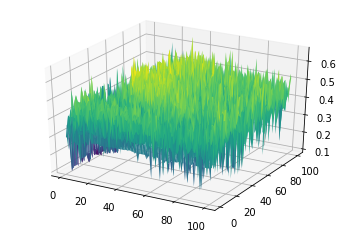

In [18]:
# print(np.amax(acc_array))
X = np.linspace(1, 100, 100)
Y = np.linspace(1, 100, 100)
X, Y = np.meshgrid(X, Y)

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, acc_tab, rstride=1, cstride=1,cmap='viridis',edgecolor='none')

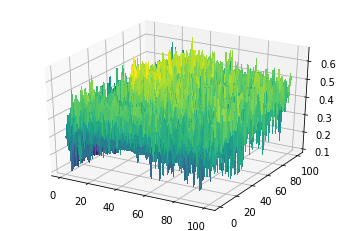

In [22]:

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, acc_tab, rstride=1, cstride=1, cmap='viridis',
    linewidth=4, antialiased=False)
